In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import secret

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars", "/Users/sergio/CAPSTONEPROJECT/mysql-connector-j-8.1.0.jar") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [2]:
from pyspark.sql.functions import *
credit_df = spark.read.json("/Users/sergio/CAPSTONEPROJECT/cdw_sapp_credit.json")
credit_df = credit_df.withColumn('MONTH', when(length(credit_df["MONTH"]) == 1, lpad(credit_df["MONTH"], 2, '0')).otherwise(credit_df['MONTH']))
credit_df = credit_df.withColumn('DAY', when(length(credit_df["DAY"]) == 1, lpad(credit_df["DAY"], 2, '0')).otherwise(credit_df['DAY']))
                                                                 
credit_df = credit_df.withColumn("DAY,MONTH,YEAR",concat_ws("-",col("YEAR"),col("MONTH"),col("DAY"))).drop("DAY").drop("MONTH").drop("YEAR")
credit_df = credit_df.select("CREDIT_CARD_NO","DAY,MONTH,YEAR","CUST_SSN","BRANCH_CODE","TRANSACTION_TYPE", "TRANSACTION_VALUE", "TRANSACTION_ID")
credit_df = credit_df.withColumnRenamed("CREDIT_CARD_NO", "CUST_CC_NO")
credit_df = credit_df.withColumnRenamed("DAY,MONTH,YEAR", "TIMEID")

credit_df.head(6)

[Row(CUST_CC_NO='4210653349028689', TIMEID='2018-02-14', CUST_SSN=123459988, BRANCH_CODE=114, TRANSACTION_TYPE='Education', TRANSACTION_VALUE=78.9, TRANSACTION_ID=1),
 Row(CUST_CC_NO='4210653349028689', TIMEID='2018-03-20', CUST_SSN=123459988, BRANCH_CODE=35, TRANSACTION_TYPE='Entertainment', TRANSACTION_VALUE=14.24, TRANSACTION_ID=2),
 Row(CUST_CC_NO='4210653349028689', TIMEID='2018-07-08', CUST_SSN=123459988, BRANCH_CODE=160, TRANSACTION_TYPE='Grocery', TRANSACTION_VALUE=56.7, TRANSACTION_ID=3),
 Row(CUST_CC_NO='4210653349028689', TIMEID='2018-04-19', CUST_SSN=123459988, BRANCH_CODE=114, TRANSACTION_TYPE='Entertainment', TRANSACTION_VALUE=59.73, TRANSACTION_ID=4),
 Row(CUST_CC_NO='4210653349028689', TIMEID='2018-10-10', CUST_SSN=123459988, BRANCH_CODE=93, TRANSACTION_TYPE='Gas', TRANSACTION_VALUE=3.59, TRANSACTION_ID=5),
 Row(CUST_CC_NO='4210653349028689', TIMEID='2018-05-28', CUST_SSN=123459988, BRANCH_CODE=164, TRANSACTION_TYPE='Education', TRANSACTION_VALUE=6.89, TRANSACTION_ID=6)

In [3]:
customer_df = spark.read.json("/Users/sergio/CAPSTONEPROJECT/cdw_sapp_custmer.json")
customer_df = customer_df.withColumn("FIRST_NAME", initcap(col("FIRST_NAME")))
customer_df = customer_df.withColumn("MIDDLE_NAME", lower(col("MIDDLE_NAME")))
customer_df = customer_df.withColumn("LAST_NAME", initcap(col("LAST_NAME")))
customer_df = customer_df.withColumn('STREET_NAME,APT_NO', concat(col('STREET_NAME'),lit(','),col('APT_NO'))).drop("STREET_NAME").drop("APT_NO")
customer_df = customer_df.withColumn('CUST_PHONE', regexp_replace(format_number('CUST_PHONE', 0), ",", "-"))
customer_df = customer_df.select("SSN","FIRST_NAME","MIDDLE_NAME","LAST_NAME","CREDIT_CARD_NO", "STREET_NAME,APT_NO", "CUST_CITY", "CUST_STATE", "CUST_COUNTRY", "CUST_ZIP", "CUST_PHONE", "CUST_EMAIL", "LAST_UPDATED")
customer_df = customer_df.withColumnRenamed("STREET_NAME,APT_NO", "FULL_STREET_ADDRESS")
customer_df.head(5)



[Row(SSN=123456100, FIRST_NAME='Alec', MIDDLE_NAME='wm', LAST_NAME='Hooper', CREDIT_CARD_NO='4210653310061055', FULL_STREET_ADDRESS='Main Street North,656', CUST_CITY='Natchez', CUST_STATE='MS', CUST_COUNTRY='United States', CUST_ZIP='39120', CUST_PHONE='1-237-818', CUST_EMAIL='AHooper@example.com', LAST_UPDATED='2018-04-21T12:49:02.000-04:00'),
 Row(SSN=123453023, FIRST_NAME='Etta', MIDDLE_NAME='brendan', LAST_NAME='Holman', CREDIT_CARD_NO='4210653310102868', FULL_STREET_ADDRESS='Redwood Drive,829', CUST_CITY='Wethersfield', CUST_STATE='CT', CUST_COUNTRY='United States', CUST_ZIP='06109', CUST_PHONE='1-238-933', CUST_EMAIL='EHolman@example.com', LAST_UPDATED='2018-04-21T12:49:02.000-04:00'),
 Row(SSN=123454487, FIRST_NAME='Wilber', MIDDLE_NAME='ezequiel', LAST_NAME='Dunham', CREDIT_CARD_NO='4210653310116272', FULL_STREET_ADDRESS='12th Street East,683', CUST_CITY='Huntley', CUST_STATE='IL', CUST_COUNTRY='United States', CUST_ZIP='60142', CUST_PHONE='1-243-018', CUST_EMAIL='WDunham@exam

In [4]:
from pyspark.sql.types import *

branch_df = spark.read.json("/Users/sergio/CAPSTONEPROJECT/cdw_sapp_branch.json")
branch_df = branch_df.withColumn("BRANCH_PHONE",branch_df.BRANCH_PHONE.cast(IntegerType()))
branch_df = branch_df.withColumn('BRANCH_PHONE', regexp_replace(format_number('BRANCH_PHONE', 0), ",", "-"))
branch_df = branch_df.na.fill({'BRANCH_ZIP': '99999'})

branch_df.head()

Row(BRANCH_CITY='Lakeville', BRANCH_CODE=1, BRANCH_NAME='Example Bank', BRANCH_PHONE='1-234-565-276', BRANCH_STATE='MN', BRANCH_STREET='Bridle Court', BRANCH_ZIP=55044, LAST_UPDATED='2018-04-18T16:51:47.000-04:00')

In [5]:
branch_df.write.format('jdbc').options(
          url='jdbc:mysql://localhost/creditcard_capstone',
          driver='com.mysql.cj.jdbc.Driver',
          dbtable='CDW_SAPP_BRANCH',
          user=secret.user,
          password=secret.password).mode("append").save()

In [6]:
credit_df.write.format('jdbc').options(
          url='jdbc:mysql://localhost/creditcard_capstone',
          driver='com.mysql.cj.jdbc.Driver',
          dbtable='CDW_SAPP_CREDIT_CARD',
          user=secret.user,
          password=secret.password).mode("append").save()

In [7]:
customer_df.write.format('jdbc').options(
          url='jdbc:mysql://localhost/creditcard_capstone',
          driver='com.mysql.cj.jdbc.Driver',
          dbtable='CDW_SAPP_CUSTOMER',
          user=secret.user,
          password=secret.password).mode("append").save()

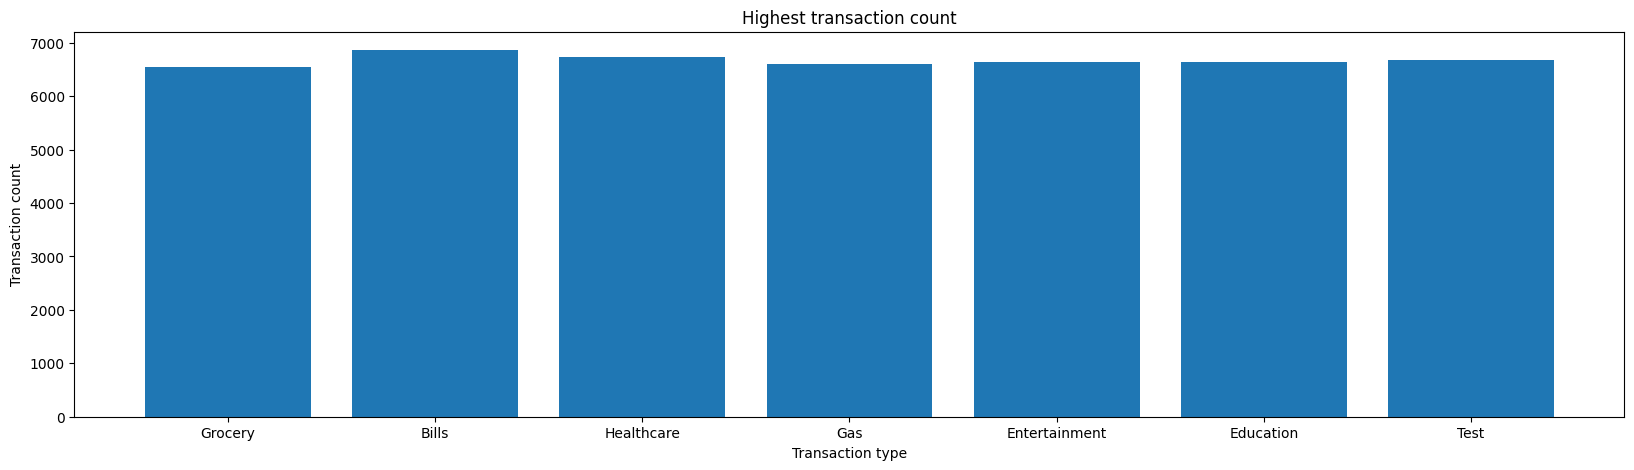

In [20]:
import pandas as pd 
import matplotlib.pyplot as plt
import mysql.connector

config = {

     'user': secret.user,
     'password': secret.password,
     'host': 'localhost',
     'database': 'creditcard_capstone'

}

db = mysql.connector.connect(**config)
cursor = db.cursor()

cursor.execute("SELECT TRANSACTION_TYPE, COUNT(*) FROM CDW_SAPP_CREDIT_CARD GROUP BY TRANSACTION_TYPE;" )
result = cursor.fetchall()
type_df = pd.DataFrame(result, columns = ["TRANSACTION_TYPE", "COUNT(*)"])


x = type_df['TRANSACTION_TYPE']
y = type_df['COUNT(*)']

plt.xlabel('Transaction type')
plt.ylabel('Transaction count')
plt.title('Highest transaction count')
plt.bar(x,y)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

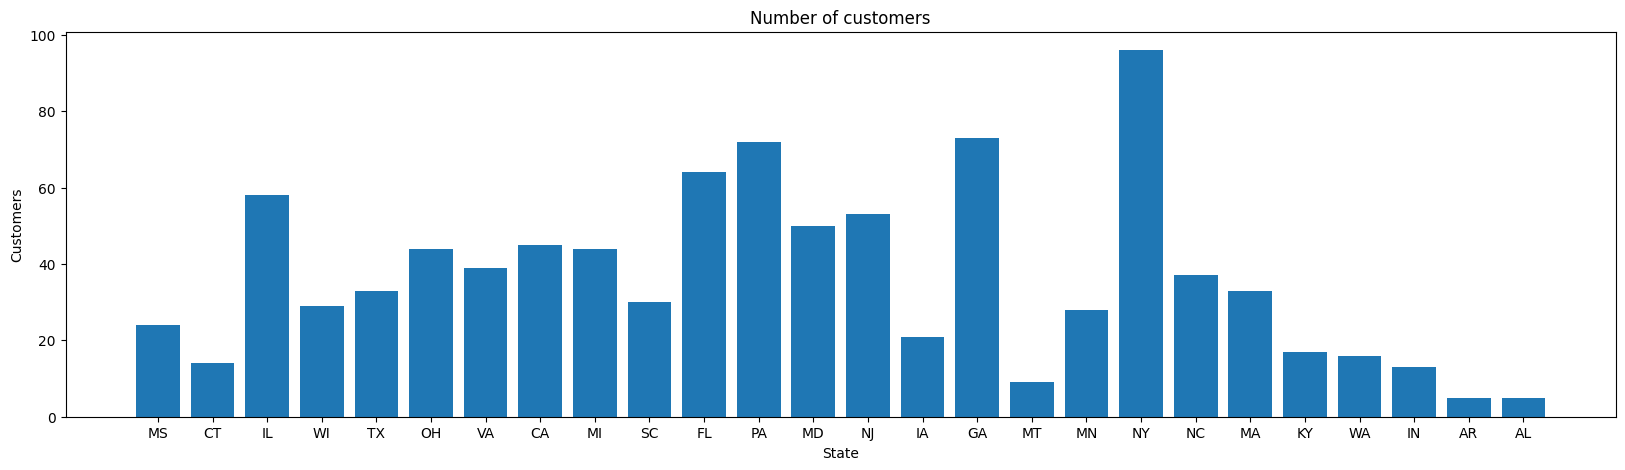

In [9]:
cursor.execute("SELECT CUST_STATE, COUNT(*) FROM CDW_SAPP_CUSTOMER GROUP BY CUST_STATE;" )
result = cursor.fetchall()
state_df = pd.DataFrame(result, columns = ["CUST_STATE", "COUNT(*)"])


x = state_df['CUST_STATE']
y = state_df['COUNT(*)']

plt.xlabel('State')
plt.ylabel('Customers')
plt.title('Number of customers')
plt.bar(x,y)
plt.show()

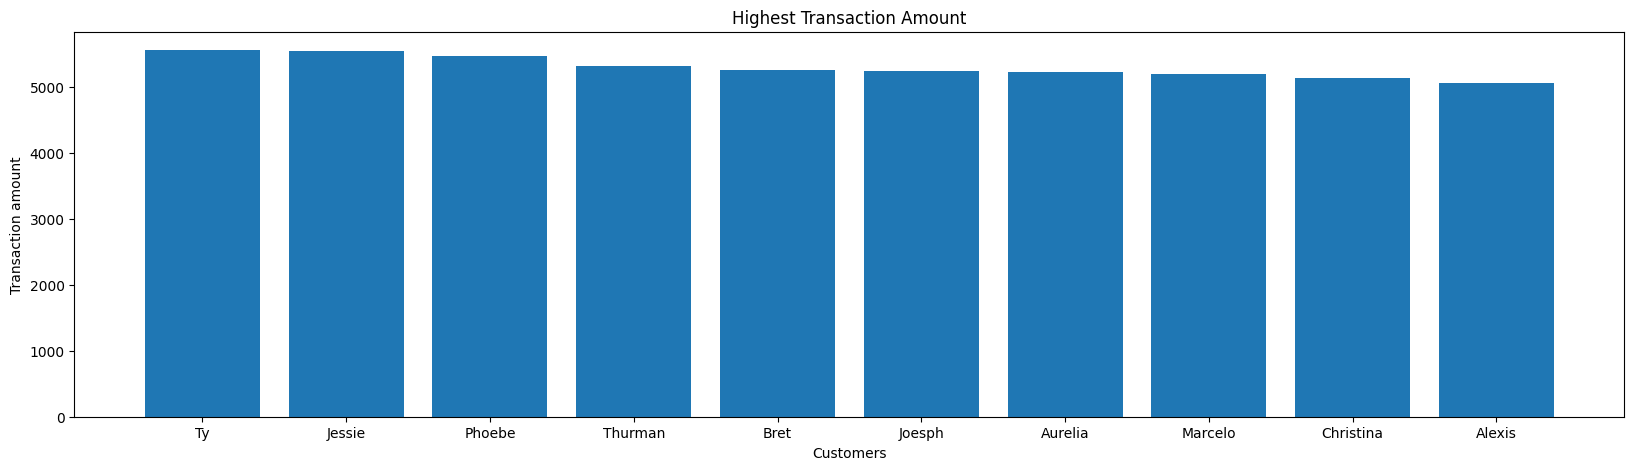

In [10]:
cursor.execute("SELECT FIRST_NAME , id, ROUND(SUM(TRANSACTION_VALUE),2) AS Amount FROM (SELECT DISTINCT CDW_SAPP_CUSTOMER.id, TRANSACTION_VALUE, FIRST_NAME FROM CDW_SAPP_CUSTOMER INNER JOIN CDW_SAPP_CREDIT_CARD ON CDW_SAPP_CUSTOMER.SSN = CDW_SAPP_CREDIT_CARD.CUST_SSN ORDER BY CDW_SAPP_CUSTOMER.id) AS NEWTABLE GROUP BY id ORDER BY ROUND(SUM(TRANSACTION_VALUE),0) DESC LIMIT 10;" )
result = cursor.fetchall()
amount_df = pd.DataFrame(result, columns = ["FIRST_NAME","id", "Amount"])


x = amount_df['FIRST_NAME']
y = amount_df['Amount']

plt.xlabel('Customers')
plt.ylabel('Transaction amount')
plt.title('Highest Transaction Amount')
plt.bar(x,y)
plt.show()

In [11]:
import requests
response = requests.get('https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json')
json = spark.sparkContext.parallelize([response.text])

loan_df = spark.read.json(json)


loan_df.head(6)


[Row(Application_ID='LP001002', Application_Status='Y', Credit_History=1, Dependents='0', Education='Graduate', Gender='Male', Income='medium', Married='No', Property_Area='Urban', Self_Employed='No'),
 Row(Application_ID='LP001003', Application_Status='N', Credit_History=1, Dependents='1', Education='Graduate', Gender='Male', Income='medium', Married='Yes', Property_Area='Rural', Self_Employed='No'),
 Row(Application_ID='LP001005', Application_Status='Y', Credit_History=1, Dependents='0', Education='Graduate', Gender='Male', Income='low', Married='Yes', Property_Area='Urban', Self_Employed='Yes'),
 Row(Application_ID='LP001006', Application_Status='Y', Credit_History=1, Dependents='0', Education='Not Graduate', Gender='Male', Income='low', Married='Yes', Property_Area='Urban', Self_Employed='No'),
 Row(Application_ID='LP001008', Application_Status='Y', Credit_History=1, Dependents='0', Education='Graduate', Gender='Male', Income='medium', Married='No', Property_Area='Urban', Self_Empl

In [12]:
status_code = response.status_code
print(status_code)

200


In [13]:
loan_df.write.format('jdbc').options(
          url='jdbc:mysql://localhost/creditcard_capstone',
          driver='com.mysql.cj.jdbc.Driver',
          dbtable='CDW_SAPP_LOAN_APPLICATION',
          user=secret.user,
          password=secret.password).mode("append").save()

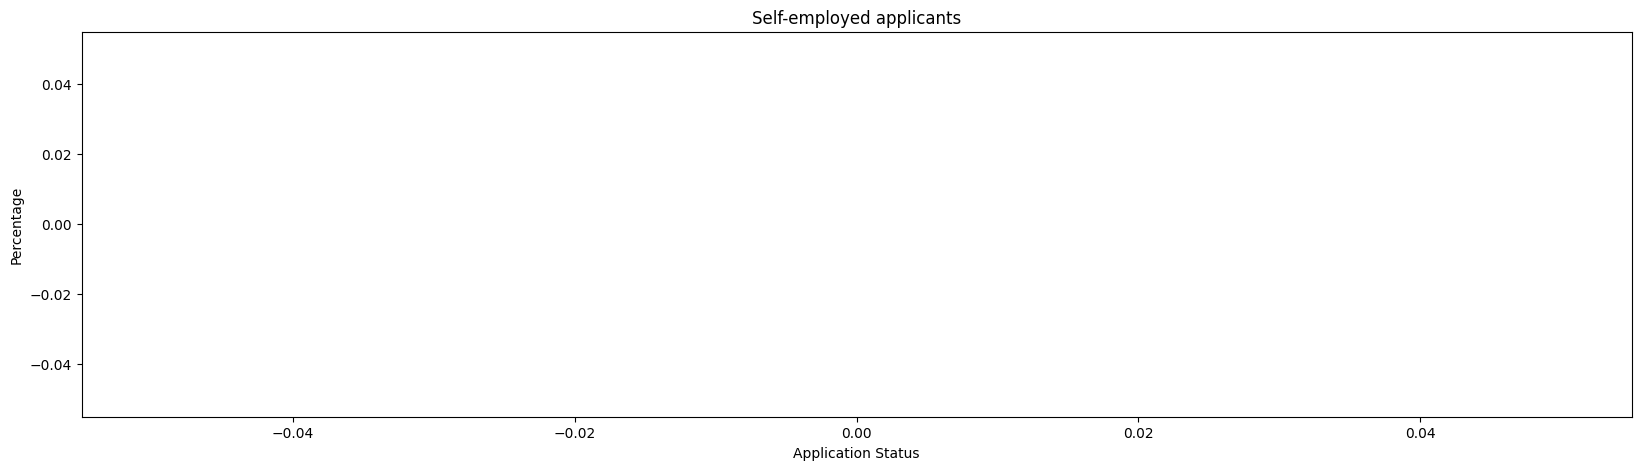

In [19]:
cursor.execute("SELECT Application_Status, 100* Count(*)/(SELECT Count(*) FROM CDW_SAPP_LOAN_APPLICATION WHERE Self_Employed = 'Yes') AS TOTAL FROM CDW_SAPP_loan_application WHERE Self_Employed = 'Yes' GROUP BY Application_Status ;" )
result = cursor.fetchall()
status_df = pd.DataFrame(result, columns = ["Application_Status", "Total"])


x = status_df['Application_Status']
y = status_df['Total']

plt.xlabel('Application Status')
plt.ylabel('Percentage')
plt.title('Self-employed applicants')
plt.bar(x,y)
plt.show()

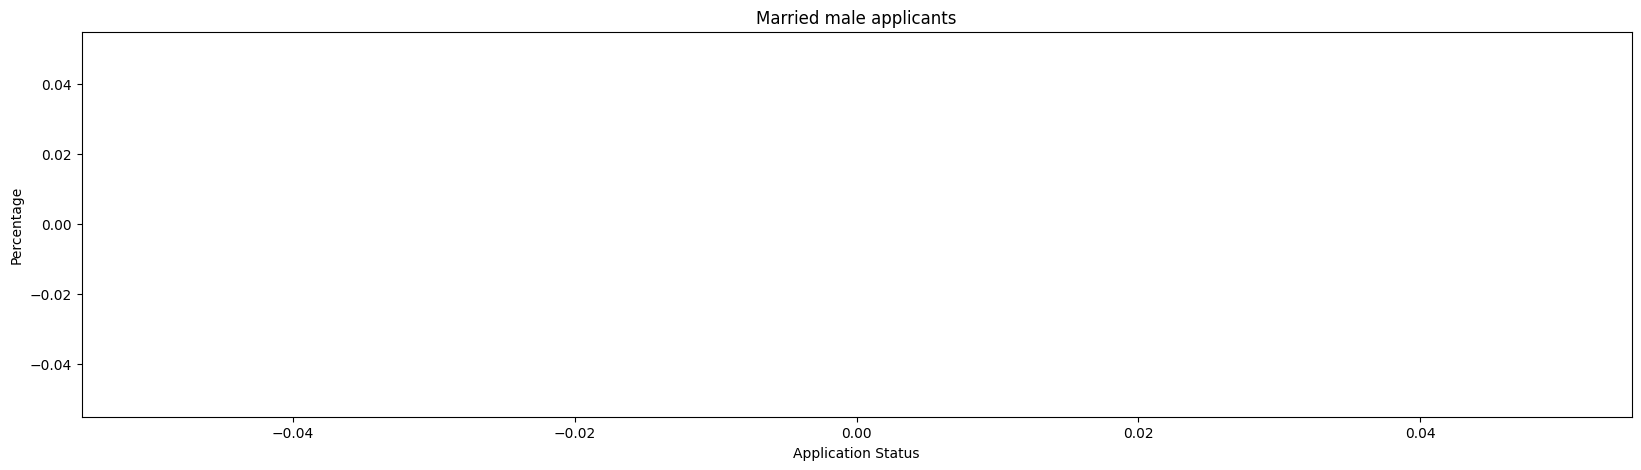

In [15]:
cursor.execute("SELECT Application_Status, 100* Count(*)/(SELECT Count(*) FROM CDW_SAPP_loan_application WHERE Married = 'Yes' and Gender = 'Male') AS TOTAL FROM CDW_SAPP_loan_application WHERE Married = 'Yes' and Gender ='Male' GROUP BY Application_Status;" )
result = cursor.fetchall()
status_df = pd.DataFrame(result, columns = ["Application_Status", "Total"])


x = status_df['Application_Status']
y = status_df['Total']

plt.xlabel('Application Status')
plt.ylabel('Percentage')
plt.title('Married male applicants')
plt.bar(x,y)
plt.show()

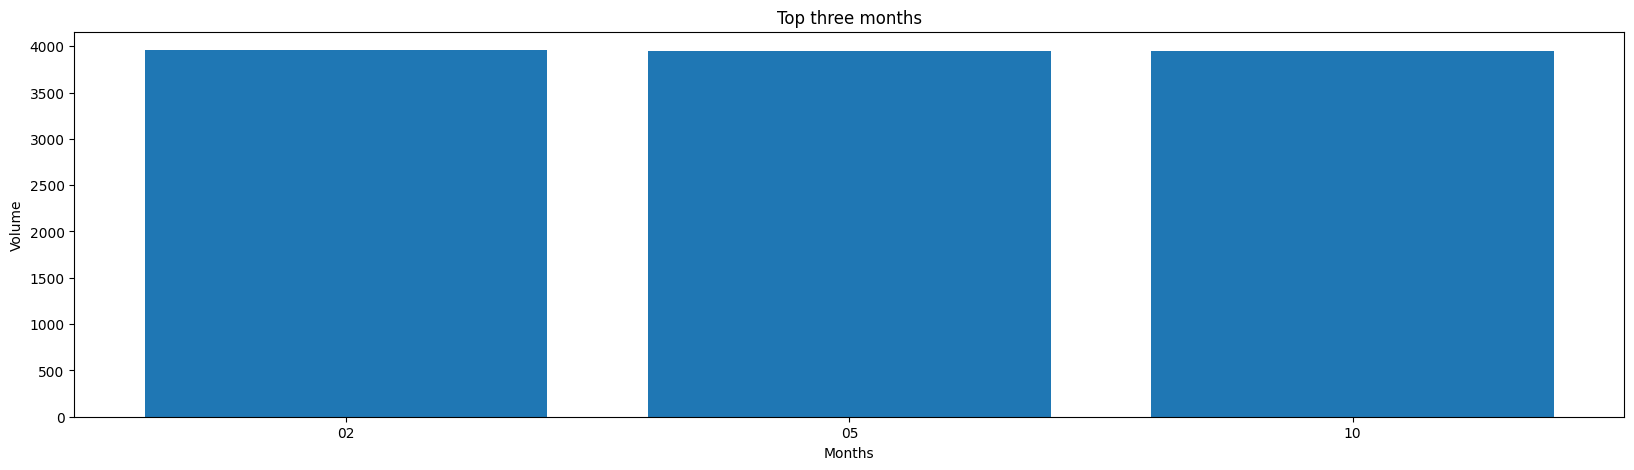

In [16]:
cursor.execute("SELECT SUBSTRING(TIMEID, 6, 2) AS MONTH, COUNT(*) AS VOLUME FROM CDW_SAPP_CREDIT_CARD GROUP BY SUBSTRING(TIMEID, 6, 2) ORDER BY COUNT(*) DESC LIMIT 3;" )
result = cursor.fetchall()
months_df = pd.DataFrame(result, columns = ["MONTH", "VOLUME"])


x = months_df['MONTH']
y = months_df['VOLUME']

plt.xlabel('Months')
plt.ylabel('Volume')
plt.title('Top three months')
plt.bar(x,y)
plt.show()

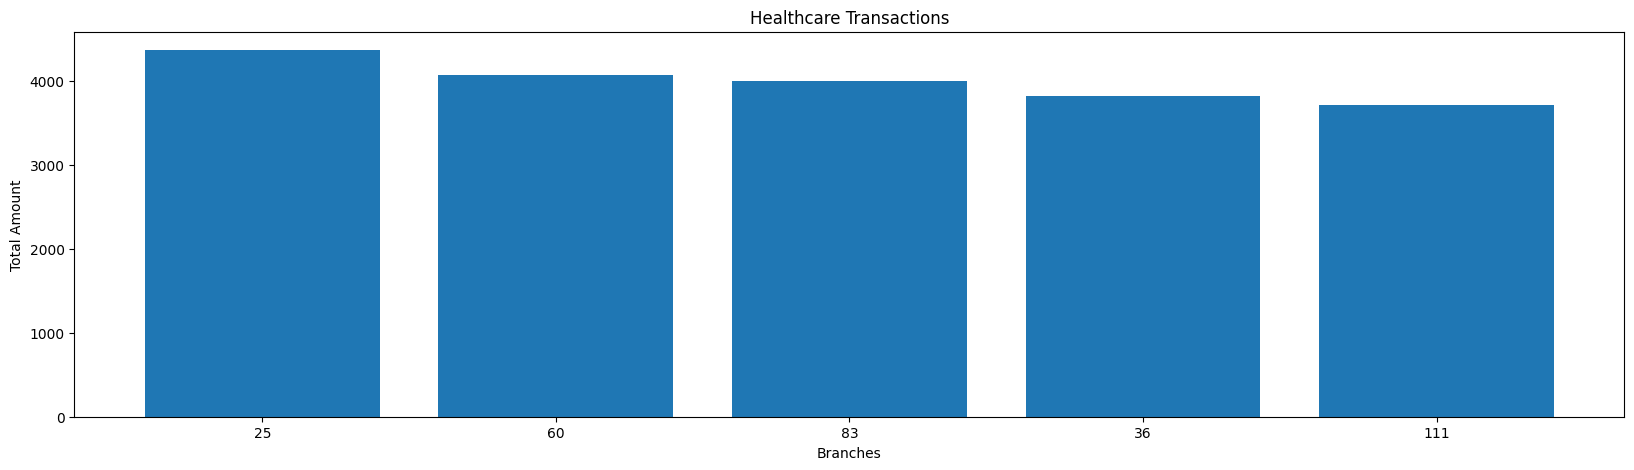

In [17]:
cursor.execute("SELECT BRANCH, ROUND(SUM(TRANSACTION_VALUE),2) AS TOTAL FROM (SELECT DISTINCT TRANSACTION_ID, CDW_SAPP_BRANCH.BRANCH_CODE AS BRANCH, TRANSACTION_VALUE, TRANSACTION_TYPE FROM CDW_SAPP_BRANCH INNER JOIN CDW_SAPP_CREDIT_CARD ON CDW_SAPP_BRANCH.BRANCH_CODE = CDW_SAPP_CREDIT_CARD.BRANCH_CODE ORDER BY TRANSACTION_ID) AS NEWTABLE WHERE TRANSACTION_TYPE = 'Healthcare' GROUP BY BRANCH ORDER BY ROUND(SUM(TRANSACTION_VALUE),2) DESC LIMIT 5;" )
result = cursor.fetchall()
health_df = pd.DataFrame(result, columns = ["BRANCH", "TOTAL"])
health_df['BRANCH'] =health_df['BRANCH'].astype(str)

x = health_df['BRANCH']
y = health_df['TOTAL']

plt.xlabel('Branches')
plt.ylabel('Total Amount')
plt.title('Healthcare Transactions')
plt.bar(x,y)
plt.show()